In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
raw_kin_df = pd.read_excel('../data/01152018rubisco_kinetics.xlsx', index_col=0)
wt_only_df = raw_kin_df[raw_kin_df.mutant == False]

# Some measurements are made at much higher temps and are not comparable.
# TODO: collect pH of measurements so we can restrict to similar range
high_T = wt_only_df.Temp_C > 30
wt_only_df = wt_only_df.loc[np.logical_not(high_T)]

# Filtered DataFrame used for most plots below.
# Only variants with all the data
kin_df = wt_only_df.copy()
has_KMs = np.logical_and(np.isfinite(kin_df.Kc), np.isfinite(kin_df.Ko))
has_kcats = np.logical_and(np.isfinite(kin_df.Vc), np.isfinite(kin_df.Vo))
has_kons = np.logical_and(np.isfinite(kin_df.kon_C), np.isfinite(kin_df.kon_O))
has_all = np.logical_and(np.logical_and(has_KMs, has_kcats), has_kons)
kin_df = kin_df[has_all]

# Want to split data in various ways
# Savir vs. Non-Savir (mostly new) data
savir_df = wt_only_df[wt_only_df.savir]
nonsavir_df = wt_only_df[wt_only_df.savir == False]

# Group by RuBisCO form
grouped_form = wt_only_df.groupby('form_text')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print wt_only_df.shape[0], 'total WT RuBisCOs'
print kin_df.shape[0], 'RuBisCOs with all core kinetic data measured'

158 total WT RuBisCOs
136 RuBisCOs with all core kinetic data measured


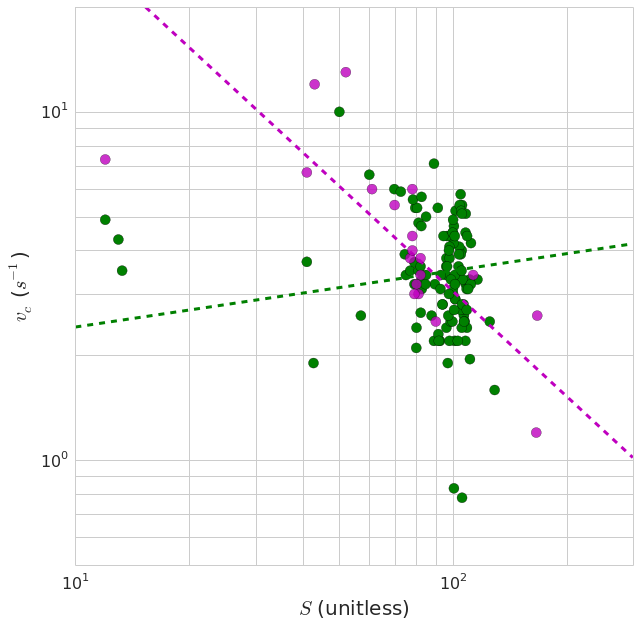

In [4]:
# Central correlation of Tcherkez2006 is S vs vC. 
# Plot data from Savir separate from new data.

# S vs. vC correlation for all data rubiscos
Ss = np.log(wt_only_df.S)
vCs = np.log(wt_only_df.Vc)
exponent, prefactor, r2 = power_laws.fit_power_law_tls(Ss, vCs)

# S vs. vC correlation for all data rubiscos
Ss_savir = np.log(savir_df.S)
vCs_savir = np.log(savir_df.Vc)
exp_sav, pre_sav, r2_sav = power_laws.fit_power_law_tls(Ss_savir, vCs_savir)

figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

# Note - axes are reversed from the Savir paper so above the line = good.
plt.scatter(savir_df.S, savir_df.Vc, c='m', s=100, label='Savir 2010', alpha=0.8, zorder=10)
plt.scatter(nonsavir_df.S, nonsavir_df.Vc, c='g', s=100, label='New Data', zorder=1)

# Plot regression of S vs vC
xs = np.arange(10, 300, 1)
predicted_ys = np.power(xs, exponent) * prefactor
plt.plot(xs, predicted_ys, ls='--', c='g', lw=3)

predicted_ys_sav = np.power(xs, exp_sav) * pre_sav
plt.plot(xs, predicted_ys_sav, ls='--', c='m', lw=3)

#plt.legend(loc=4, fontsize=18, frameon=True)
plt.xlabel('$S$ (unitless)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(10, 300)
plt.ylim(5e-1, 20)

plt.show()

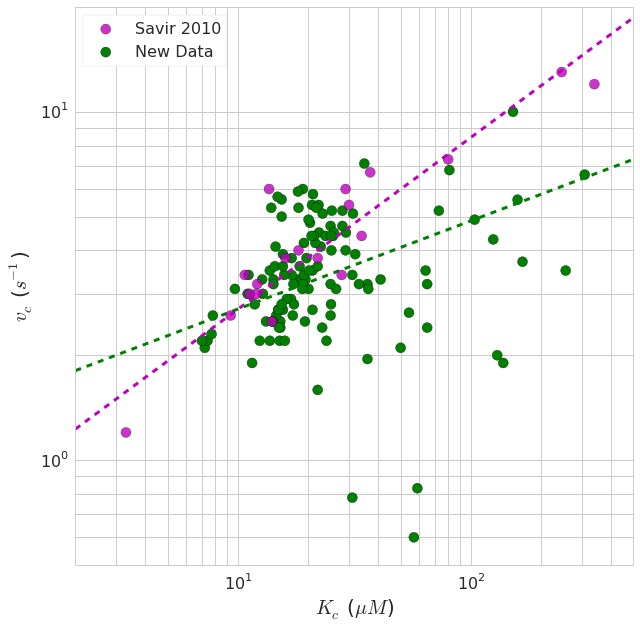

In [5]:
# Central correlation of Savir2010 is KC vs vC. 
# KC vs. vC correlation for all data rubiscos
KCs = np.log(wt_only_df.Kc)
vCs = np.log(wt_only_df.Vc)

exponent, prefactor, r2 = power_laws.fit_power_law_tls(KCs, vCs)

# Here we plot data from Savir separate from new data.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

# Note - axes are reversed from the Savir paper so above the line = good.
plt.scatter(savir_df.Kc, savir_df.Vc, c='m', s=100, label='Savir 2010', alpha=0.8, zorder=10)
plt.scatter(nonsavir_df.Kc, nonsavir_df.Vc, c='g', s=100, label='New Data')

# Plot Savir's power law for Kc vs. Vc
# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs_savir = np.power(xs/1.32, 1.0/2.03)
projected_Vcs = np.power(xs, exponent)*prefactor

plt.plot(xs, projected_Vcs_savir, ls='--', c='m', lw=3)
plt.plot(xs, projected_Vcs, ls='--', c='g', lw=3)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.show()

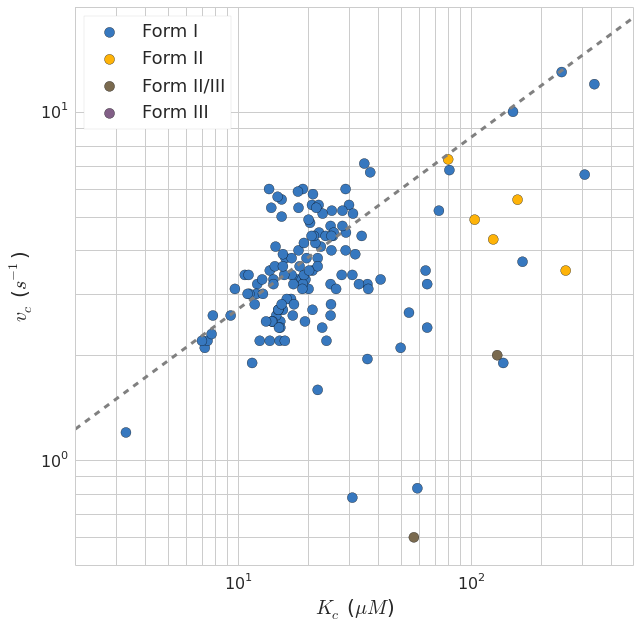

In [6]:
# Plot Kc vs. Vc coloring by RuBisCO form.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

for i, (group, gdf) in enumerate(grouped_form):
    label = 'Form %s' % group
    c = named_colors[i]
    plt.scatter(gdf.Kc, gdf.Vc, c=c, s=100, label=label)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', c='grey', lw=3)

plt.legend(loc=2, fontsize=18, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.show()

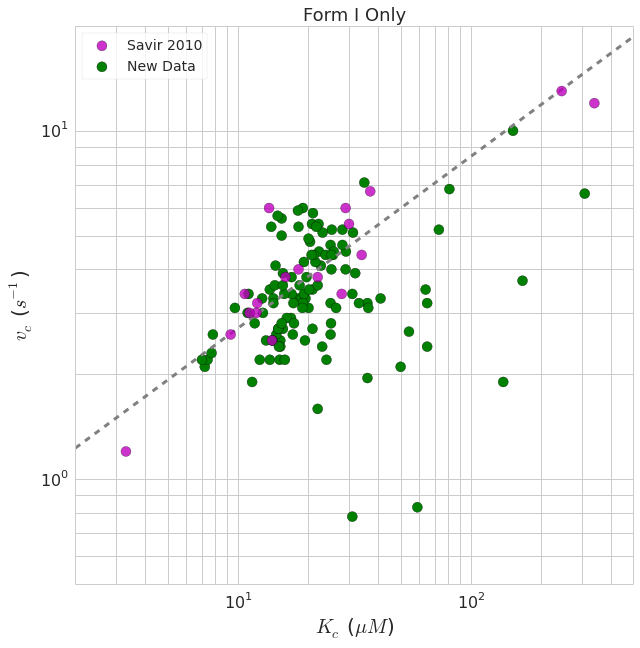

In [7]:
# Plot Kc vs. Vc for FI RuBisCOs alone
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("BrBG", 15)
fIs = grouped_form.get_group('I')
subset = np.logical_and(np.isfinite(fIs.Kc), np.isfinite(fIs.Vc))
fIs = fIs[subset]
fIs_nonsavir = fIs[fIs.savir == False]
savir_FIs = fIs[fIs.savir == True]

plt.scatter(savir_FIs.Kc, savir_FIs.Vc, c='m', s=100, label='Savir 2010', alpha=0.8, zorder=10)
plt.scatter(fIs_nonsavir.Kc, fIs_nonsavir.Vc, c='g', s=100, label='New Data')


# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', c='grey', lw=3)

leg = plt.legend(loc=2, fontsize=14, frameon=True)
leg.get_frame().set_alpha(0.8)
plt.title('Form I Only', fontsize=18)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.show()

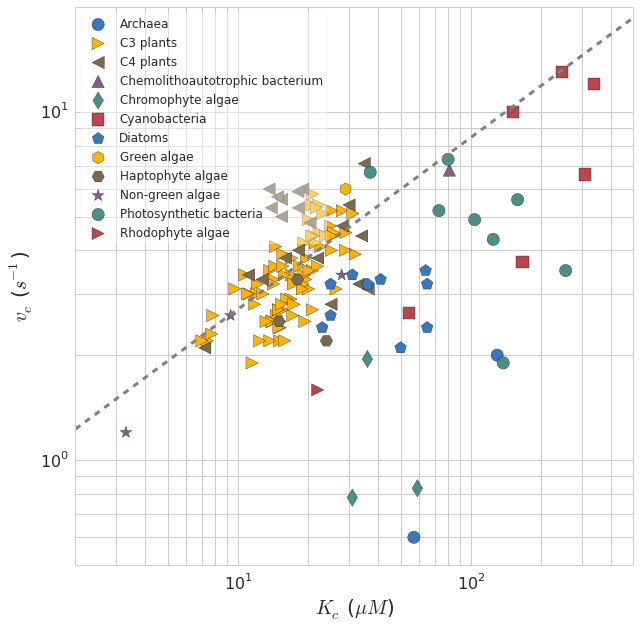

In [8]:
# Kc vs. Vc - show new data by taxonomic grouping of the organism. 
# Notice again the wide spread in photosynthetic bacteria being due to the
# very large deviations in measurements for the Rubrum FII enzyme.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

grouped_taxon = wt_only_df.groupby('Taxonomy')

for i, (group, gdf) in enumerate(grouped_taxon):
    marker = markers[i % len(markers)]
    # Hack here: since scatter accepts a list of colors, a tuple color specification won't work since it 
    # can be confused with a list. So I convert to hex for clarity.
    c = matplotlib.colors.rgb2hex(named_colors[i % len(named_colors)])
    plt.scatter(gdf.Kc, gdf.Vc, label=group, s=150, c=c, marker=marker)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', c='grey', lw=3)

leg = plt.legend(loc=2, fontsize=12, frameon=True)
leg.get_frame().set_alpha(0.4)

plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.show()

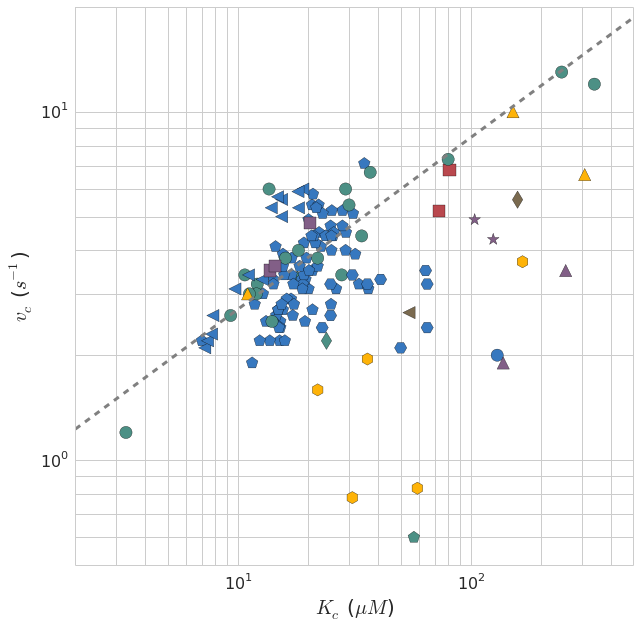

In [9]:
# Kc vs. Vc - show new data by reference to see if there is some lab-lab variation. 
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

grouped_ref = wt_only_df.groupby('short_ref')

for i, (group, gdf) in enumerate(grouped_ref):
    marker = markers[i % len(markers)]
    # Hack here: since scatter accepts a list of colors, a tuple color specification won't work since it 
    # can be confused with a list. So I convert to hex for clarity.
    c = matplotlib.colors.rgb2hex(named_colors[i % len(named_colors)])
    
    # Need to mask in this case because there are NaNs among the data.
    mask = ~ np.isnan(gdf.Kc) & ~ np.isnan(gdf.Vc)
    masked = gdf[mask]
    plt.scatter(masked.Kc, masked.Vc, label=group, s=150, c=c, marker=marker)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', c='grey', lw=3)

# Omitting legend because it hides a lot of data here (many refs)
#leg = plt.legend(loc=2, fontsize=12, frameon=True)
#leg.get_frame().set_alpha(0.4)

plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(5e-1, 20)
plt.xlim(2, 5e2)

plt.show()

In [10]:
# KC vs. VC correlation over entire dataset
KCs = np.log(wt_only_df.Kc)
vCs = np.log(wt_only_df.Vc)

exponent, prefactor, r2 = power_laws.fit_power_law_tls(KCs, vCs)

print 'R^2 =', r2
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)

R^2 = 0.0457054711152
y = 1.52 x^(0.253)


In [11]:
# KC vs. VC correlation for FIs only
FIs = wt_only_df[wt_only_df.form_text == 'I']
KCs = np.log(FIs.Kc)
vCs = np.log(FIs.Vc)

exponent, prefactor, r2 = power_laws.fit_power_law_tls(KCs, vCs)

print 'R^2 =', r2
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)

R^2 = 0.141478197469
y = 1.23 x^(0.335)


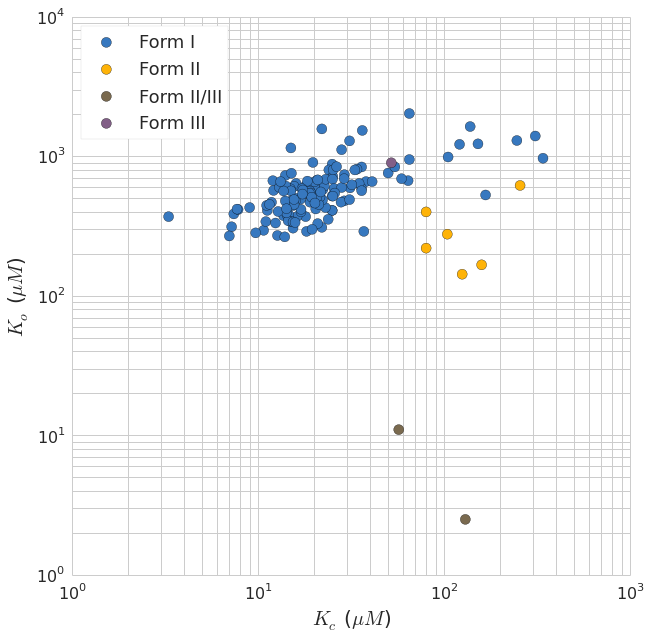

In [12]:
# Plot Kc vs. Ko coloring by RuBisCO form.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

for i, (group, gdf) in enumerate(grouped_form):
    label = 'Form %s' % group
    c = named_colors[i]
    plt.scatter(gdf.Kc, gdf.Ko, c=c, s=100, label=label)

plt.legend(loc=2, fontsize=18, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$K_o$ ($\mu M$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.ylim(5e-1, 20)
#plt.xlim(2, 5e2)

plt.show()

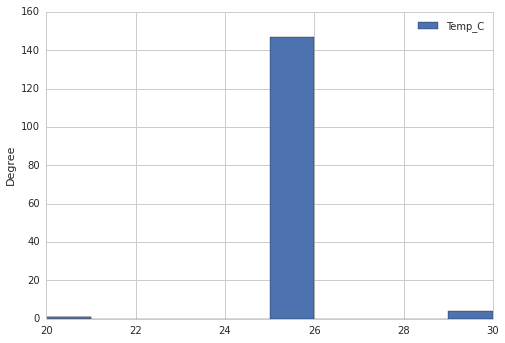

In [19]:
wt_only_df.plot(kind='hist', y='Temp_C')

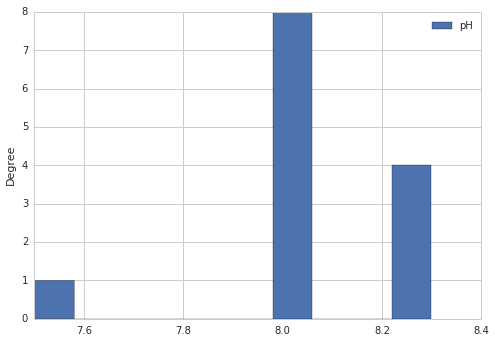

In [21]:
wt_only_df.plot(kind='hist', y='pH')